# IBM Watson OpenScale Lab instructions

This notebook should be run in a Watson Studio project, using with **Python 3.5 with Spark** runtime environment. **If you are viewing this in Watson Studio and do not see Python 3.5 with Spark in the upper right corner of your screen, please update the runtime now.** It requires service credentials for the following Cloud services:
  * IBM Watson OpenScale
  * Watson Machine Learning
  
If you have a paid Cloud account, you may also provision a **Databases for PostgreSQL** or **Db2 Warehouse** service to take full advantage of integration with Watson Studio and continuous learning services. If you choose not to provision this paid service, you can use the free internal PostgreSQL storage with OpenScale, but will not be able to configure continuous learning for your model.

The notebook will train, create and deploy a Propensity to Buy Model, configure OpenScale to monitor that deployment, and inject seven days' worth of historical records and measurements for viewing in the OpenScale Insights dashboard.

# Business Scenario

Three years ago, National Motor Company (NMC) began selling 3rd party ads in their connected dashboards. NMC used machine learning models to ensure that offers were timely and relevant. Only customers who were likely to buy, received an offer.
Originally, only the "High-End" luxury models contained the connected dashboards. Delivering timely ads to consumers while driving in their car was a major success. NMC increased revenue by selling ad space in their vehicles. Advertisers benefited from new sales and consumers recieved recieved money saving deals.

Now, NMC is rolling out the connected dashboards to their "Mid-Range" brands. Unfortunately, they don't have much history of ads being offered to "Mid-Range" vehicles. This means there is a high potential for bias and a decline in accuracy during the roll-out. 

NMC's goal is to maintain the accuracy of their current machine learning models and make sure that offers are delivered fairly to both "High-End' and "Mid-Range" Vehicles. The achieve this, they turned to IBM's Watson Open Scale.


# Package installation

In [ ]:
!rm -rf $PIP_BUILD
!pip install psycopg2-binary | tail -n 1
!pip install --upgrade watson-machine-learning-client --no-cache | tail -n 1
!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1
!pip install --upgrade numpy --no-cache | tail -n 1
!pip install --upgrade lime --no-cache | tail -n 1
!pip install --upgrade SciPy --no-cache | tail -n 1

# Provision services and configure credentials

If you have not already, provision an instance of IBM Watson OpenScale using the [OpenScale link in the Cloud catalog](https://cloud.ibm.com/catalog/services/ai-openscale).

Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

In [1]:
CLOUD_API_KEY = "Insert Cloud API Key Here"

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190429155343-0000
KERNEL_ID = a9ebdf38-ed09-4384-8c67-e9ef783081c5


Next you will need credentials for Watson Machine Learning. If you already have a WML instance, you may use credentials for it. To provision a new Lite instance of WML, use the [Cloud catalog](https://cloud.ibm.com/catalog/services/machine-learning), give your service a name, and click **Create**. Once your instance is created, click the **Service Credentials** link on the left side of the screen. Click the **New credential** button, give your credentials a name, and click **Add**. Your new credentials can be accessed by clicking the **View credentials** button. Copy and paste your WML credentials into the cell below.

In [2]:
WML_CREDENTIALS ={Insert Credentials Here}

SyntaxError: invalid syntax (<ipython-input-2-0d3b4c3c9990>, line 1)

This lab can use Databases for PostgreSQL, Db2 Warehouse, or a free internal verison of PostgreSQL to create a datamart for OpenScale.

If you have previously configured OpenScale, it will use your existing datamart, and not interfere with any models you are currently monitoring. Do not update the cell below.

If you do not have a paid Cloud account or would prefer not to provision this paid service, you may use the free internal PostgreSQL service with OpenScale. Do not update the cell below.

To provision a new instance of Db2 Warehouse, locate [Db2 Warehouse in the Cloud catalog](https://cloud.ibm.com/catalog/services/db2-warehouse), give your service a name, and click **Create**. Once your instance is created, click the **Service Credentials** link on the left side of the screen. Click the **New credential** button, give your credentials a name, and click **Add**. Your new credentials can be accessed by clicking the **View credentials** button. Copy and paste your Db2 Warehouse credentials into the cell below.

To provision a new instance of Databases for PostgreSQL, locate [Databases for PostgreSQL in the Cloud catalog](https://cloud.ibm.com/catalog/services/databases-for-postgresql), give your service a name, and click **Create**. Once your instance is created, click the **Service Credentials** link on the left side of the screen. Click the **New credential** button, give your credentials a name, and click **Add**. Your new credentials can be accessed by clicking the **View credentials** button. Copy and paste your Databases for PostgreSQL credentials into the cell below.

In [ ]:
DB_CREDENTIALS = None

__If you previously configured OpenScale to use the free internal version of PostgreSQL, you can switch to a new datamart using a paid database service.__ If you would like to delete the internal PostgreSQL configuration and create a new one using service credentials supplied in the cell above, set the __KEEP_MY_INTERNAL_POSTGRES__ variable below to __False__ below. In this case, the notebook will remove your existing internal PostgreSQL datamart and create a new one with the supplied credentials. __*NO DATA MIGRATION WILL OCCUR.*__

In [ ]:
KEEP_MY_INTERNAL_POSTGRES = True

# Run the notebook

At this point, the notebook is ready to run. You can either run the cells one at a time, or click the **Kernel** option above and select **Restart and Run All** to run all the cells.

# Load and explore data

## Load the training data from github

In [ ]:
!rm df_training.csv
!wget https://raw.githubusercontent.com/shadgriffin/propensitytobuylab/master/df_training.csv

In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
pd_data = pd.read_csv("df_training.csv", sep=",", header=0)
df_data = spark.read.csv(path="df_training.csv", sep=",", header=True, inferSchema=True)
df_data.head()

In [ ]:
pd_data.shape


## Explore data

In [ ]:
df_data.printSchema()

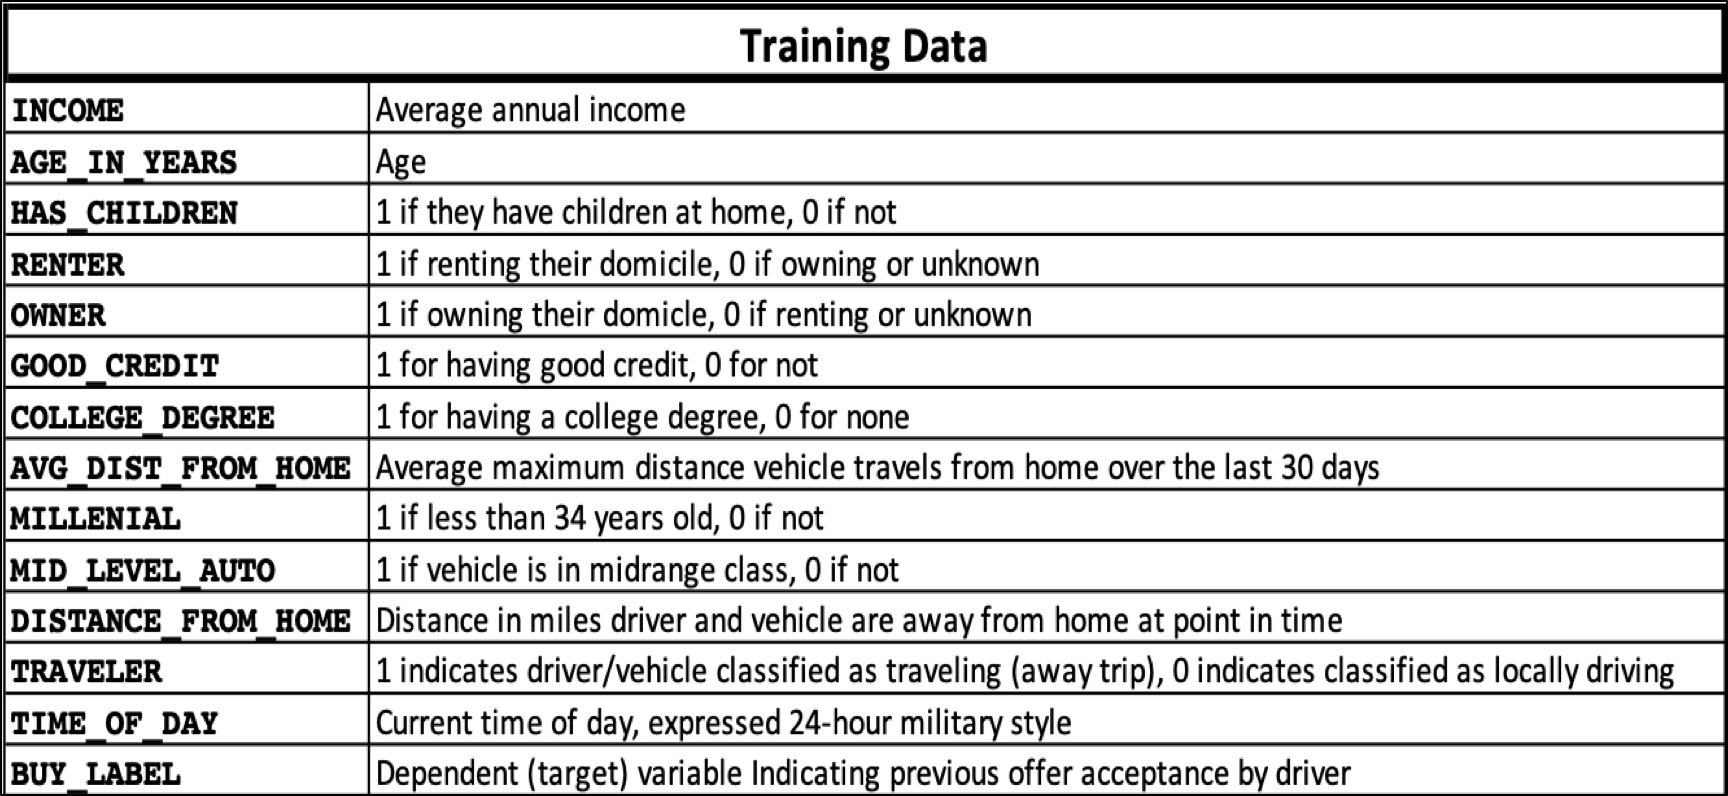

In [ ]:
df_data.count()

In [ ]:
print("Number of records: " + str(df_data.count()))

# Create a model

In [ ]:
spark_df = df_data
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

MODEL_NAME = "Propensity Model"
DEPLOYMENT_NAME = "Propensity Model"

print("Number of records for training: " + str(train_data.count()))
print("Number of records for evaluation: " + str(test_data.count()))

spark_df.printSchema()

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model


In [ ]:
si_Label = StringIndexer(inputCol="BUY_LABEL", outputCol="label").fit(spark_df)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si_Label.labels)

In [ ]:
va_features = VectorAssembler(inputCols=["INCOME", "AGE_IN_YEARS", "HAS_CHILDREN", "RENTER", "OWNER", "GOOD_CREDIT", "COLLEGE_DEGREE", \
                                         "AVG_DIST_FROM_HOME","MILLENIAL","MID_LEVEL_AUTO","DISTANCE_FROM_HOME","TRAVELER","TIME_OF_DAY"], outputCol="features")

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
classifier = RandomForestClassifier(featuresCol="features")

pipeline = Pipeline(stages=[ si_Label, va_features, classifier, label_converter])
model = pipeline.fit(train_data)

In [ ]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction")
area_under_curve = evaluatorDT.evaluate(predictions)

#default evaluation is areaUnderROC
print("areaUnderROC = %g" % area_under_curve)

# Save and deploy the model

In [ ]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import json

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

### Remove existing model and deployment

In [ ]:
model_deployment_ids = wml_client.deployments.get_uids()
for deployment_id in model_deployment_ids:
    deployment = wml_client.deployments.get_details(deployment_id)
    model_id = deployment['entity']['deployable_asset']['guid']
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)
wml_client.repository.list_models()

In [ ]:
model_props = {
    wml_client.repository.ModelMetaNames.NAME: "{}".format(MODEL_NAME),
    wml_client.repository.ModelMetaNames.EVALUATION_METHOD: "binary",
    wml_client.repository.ModelMetaNames.EVALUATION_METRICS: [
        {
           "name": "areaUnderROC",
           "value": area_under_curve,
           "threshold": 0.75
        }
    ]
}

In [ ]:
wml_models = wml_client.repository.get_details()
model_uid = None
for model_in in wml_models['models']['resources']:
    if MODEL_NAME == model_in['entity']['name']:
        model_uid = model_in['metadata']['guid']
        break

if model_uid is None:
    print("Storing model ...")

    published_model_details = wml_client.repository.store_model(model=model, meta_props=model_props, training_data=train_data, pipeline=pipeline)
    model_uid = wml_client.repository.get_model_uid(published_model_details)
    print("Done")

In [ ]:
model_uid

In [ ]:
wml_deployments = wml_client.deployments.get_details()
deployment_uid = None
for deployment in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        deployment_uid = deployment['metadata']['guid']
        break

if deployment_uid is None:
    print("Deploying model...")

    deployment = wml_client.deployments.create(artifact_uid=model_uid, name=DEPLOYMENT_NAME, asynchronous=False)
    deployment_uid = wml_client.deployments.get_uid(deployment)
    
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))

# Configure OpenScale

In [ ]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *

### Get AI OpenScale GUID

In [ ]:
import requests

AIOS_GUID = None
token_data = {
    'grant_type': 'urn:ibm:params:oauth:grant-type:apikey',
    'response_type': 'cloud_iam',
    'apikey': CLOUD_API_KEY
}

response = requests.post('https://iam.bluemix.net/identity/token', data=token_data)
iam_token = response.json()['access_token']
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

resources = json.loads(requests.get('https://resource-controller.cloud.ibm.com/v2/resource_instances', headers=iam_headers).text)['resources']
for resource in resources:
    if "aiopenscale" in resource['id'].lower():
        AIOS_GUID = resource['guid']
        
AIOS_CREDENTIALS = {
    "instance_guid": AIOS_GUID,
    "apikey": CLOUD_API_KEY,
    "url": "https://api.aiopenscale.cloud.ibm.com"
}

if AIOS_GUID is None:
    print('AI OpenScale GUID NOT FOUND')
else:
    print(AIOS_GUID)

## Create schema and datamart

In [ ]:
ai_client = APIClient(aios_credentials=AIOS_CREDENTIALS)
ai_client.version
time.sleep(20)

### Set up datamart

In [ ]:
try:
    data_mart_details = ai_client.data_mart.get_details()
    if 'internal_database' in data_mart_details and data_mart_details['internal_database']:
        if KEEP_MY_INTERNAL_POSTGRES:
            print('Using existing internal datamart.')
        else:
            if DB_CREDENTIALS is None:
                print('No postgres credentials supplied. Using existing internal datamart')
            else:
                print('Switching to external datamart')
                ai_client.data_mart.delete(force=True)
                ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS)
    else:
        print('Using existing external datamart')
except:
    if DB_CREDENTIALS is None:
        print('Setting up internal datamart')
        ai_client.data_mart.setup(internal_db=True)
    else:
        print('Setting up external datamart')
        ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS)
    

In [ ]:
data_mart_details = ai_client.data_mart.get_details()
data_mart_details

## Bind machine learning engines

In [ ]:
binding_uid = ai_client.data_mart.bindings.add('WML instance', WatsonMachineLearningInstance(WML_CREDENTIALS))
if binding_uid is None:
    binding_uid = ai_client.data_mart.bindings.get_details()['service_bindings'][0]['metadata']['guid']
bindings_details = ai_client.data_mart.bindings.get_details()
ai_client.data_mart.bindings.list()

In [ ]:
print(binding_uid)

In [ ]:
ai_client.data_mart.bindings.list_assets()

## Subscriptions

### Remove existing  propensity to buy subscriptions

In [ ]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
for subscription in subscriptions_uids:
    sub_name = ai_client.data_mart.subscriptions.get_details(subscription)['entity']['asset']['name']
    if sub_name == MODEL_NAME:
        ai_client.data_mart.subscriptions.delete(subscription)
        print('Deleted existing subscription for', MODEL_NAME)

In [ ]:
subscription = ai_client.data_mart.subscriptions.add(WatsonMachineLearningAsset(
    model_uid,
    problem_type=ProblemType.BINARY_CLASSIFICATION,
    input_data_type=InputDataType.STRUCTURED,
    label_column='BUY_LABEL',
    prediction_column='predictedLabel',
    probability_column='probability',
    feature_columns = ["INCOME", "AGE_IN_YEARS", "HAS_CHILDREN", "RENTER", "OWNER", "GOOD_CREDIT", "COLLEGE_DEGREE","AVG_DIST_FROM_HOME",
                       "MILLENIAL","MID_LEVEL_AUTO","DISTANCE_FROM_HOME","TRAVELER","TIME_OF_DAY"],
    categorical_columns = ["HAS_CHILDREN", "RENTER", "OWNER", "GOOD_CREDIT", "COLLEGE_DEGREE","MILLENIAL","MID_LEVEL_AUTO","TRAVELER"]
))

if subscription is None:
    print('Subscription already exists; get the existing one')
    subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
    for sub in subscriptions_uids:
        if ai_client.data_mart.subscriptions.get_details(sub)['entity']['asset']['name'] == MODEL_NAME:
            subscription = ai_client.data_mart.subscriptions.get(sub)

Get subscription list

In [ ]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
ai_client.data_mart.subscriptions.list()

In [ ]:

subscription.get_details()

### Score the model so we can configure monitors

In [ ]:
propensity_to_buy_scoring_endpoint = None
print(deployment_uid)

for deployment in wml_client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['guid']:
        propensity_to_buy_scoring_endpoint = deployment['entity']['scoring_url']
        
print(propensity_to_buy_scoring_endpoint)

In [ ]:
fields = ["INCOME", "AGE_IN_YEARS", "HAS_CHILDREN", "RENTER","OWNER", "GOOD_CREDIT", "COLLEGE_DEGREE", "AVG_DIST_FROM_HOME","MILLENIAL", "MID_LEVEL_AUTO",
          "DISTANCE_FROM_HOME", "TRAVELER", "TIME_OF_DAY"]
values = [
[87500.0048,82.728962,0.0,0,1,1,0,9.16,0,1,3,0,18],
[47500.0006,31.970484,0.0,0,1,1,1,14.7,1,1,3,0,12],
[250000.007,61.898855,0.0,0,1,1,1,13.5,0,1,9,0,18],
[17500.0087,79.146277,0.0,0,1,1,0,0.11,0,1,1,0,11],
[125000.0015,70.388906,0.0,0,1,1,1,6.76,0,0,1,0,15],
[62500.0075,36.73303,1.0,0,1,1,0,22.86,0,0,13,0,10],
[87500.0018,65.726646,1.0,0,1,1,0,26.65,0,0,18,0,13],
[87500.0046,63.057304,0.0,0,1,1,0,13.86,0,1,2,0,6],
[62500.0085,57.147446,1.0,0,1,0,0,43.54,0,1,31,0,18],
[17500.0053,60.14493,0.0,0,1,1,0,3.1,0,1,9,0,12]
]

payload_scoring = {"fields": fields,"values": values}
scoring_response = wml_client.deployments.score(propensity_to_buy_scoring_endpoint, payload_scoring)

print(scoring_response)

## Quality and feedback monitoring

### Enable quality monitoring

Wait ten seconds to allow the payload logging table to be set up before we begin enabling monitors.

In [ ]:
time.sleep(10)
subscription.quality_monitoring.enable(threshold=0.7, min_records=50)

### Feedback logging

In [ ]:
!rm df_feedback.json
!wget https://raw.githubusercontent.com/shadgriffin/propensitytobuylab/master/df_feedback.json

In [ ]:
with open('df_feedback.json') as feedback_file:
    df_feedback = json.load(feedback_file)
subscription.feedback_logging.store(df_feedback['data'])

In [ ]:
subscription.feedback_logging.show_table()

In [ ]:
run_details = subscription.quality_monitoring.run()
status = run_details['status']
id = run_details['id']
print(id)

print("Run status: {}".format(status))

start_time = time.time()
elapsed_time = 0

while status != 'completed' and elapsed_time < 60:
    time.sleep(10)
    run_details = subscription.quality_monitoring.get_run_details(run_uid=id)
    status = run_details['status']
    elapsed_time = time.time() - start_time
    print("Run status: {}".format(status))

In [ ]:
subscription.quality_monitoring.get_run_details()

In [ ]:
subscription.quality_monitoring.show_table()

In [ ]:
#subscription.quality_monitoring._get_data_from_rest_api()

In [ ]:
ai_client.data_mart.get_deployment_metrics()

## Fairness monitoring

In [ ]:
subscription.fairness_monitoring.enable(
            features=[
                Feature("MID_LEVEL_AUTO", majority=[[0,0]], minority=[[1,1]], threshold=0.80)
            ],
            favourable_classes=['OFFER'],
            unfavourable_classes=['NO_OFFER'],
            min_records=1000,
            training_data=pd_data
        )

## Score the model again now that monitoring is configured

In [ ]:
!rm df_payload_scoring.json
!wget https://raw.githubusercontent.com/shadgriffin/propensitytobuylab/master/df_payload_scoring.json

Score 1000 randomly chosen records

In [ ]:
import random

with open('df_payload_scoring.json', 'r') as scoring_file:
    scoring_data = json.load(scoring_file)

fields = scoring_data['fields']
values = []
for _ in range(1000):
    values.append(random.choice(scoring_data['values']))
payload_scoring = {"fields": fields, "values": values}

scoring_response = wml_client.deployments.score(propensity_to_buy_scoring_endpoint, payload_scoring)
print(scoring_response)

In [ ]:
payload_scoring

In [ ]:
subscription.get_details()

# Insert historical payloads

In [ ]:
!rm payload_history*.json
!wget https://raw.githubusercontent.com/shadgriffin/propensitytobuylab/master/payload_history_1.json
!wget https://raw.githubusercontent.com/shadgriffin/propensitytobuylab/master/payload_history_2.json
!wget https://raw.githubusercontent.com/shadgriffin/propensitytobuylab/master/payload_history_3.json
!wget https://raw.githubusercontent.com/shadgriffin/propensitytobuylab/master/payload_history_4.json
!wget https://raw.githubusercontent.com/shadgriffin/propensitytobuylab/master/payload_history_5.json
!wget https://raw.githubusercontent.com/shadgriffin/propensitytobuylab/master/payload_history_6.json
!wget https://raw.githubusercontent.com/shadgriffin/propensitytobuylab/master/payload_history_7.json

In [ ]:
historyDays = 7
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
import datetime
import time

In [ ]:
data_mart_id = subscription.get_details()['metadata']['url'].split('/service_bindings')[0].split('marts/')[1]
print(data_mart_id)

In [ ]:
performance_metrics_url = 'https://api.aiopenscale.cloud.ibm.com' + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/metrics'
print(performance_metrics_url)

## Insert historical fairness metrics

In [ ]:
!rm fairness_records.json
!wget https://raw.githubusercontent.com/shadgriffin/propensitytobuylab/master/fairness_records.json
import random

In [ ]:

token_data = {
    'grant_type': 'urn:ibm:params:oauth:grant-type:apikey',
    'response_type': 'cloud_iam',
    'apikey': AIOS_CREDENTIALS['apikey']
}

response = requests.post('https://iam.bluemix.net/identity/token', data=token_data)
iam_token = response.json()['access_token']
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

with open('fairness_records.json', 'r') as history_file:
    payloads = json.load(history_file)

for day in range(historyDays):
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        
        qualityMetric = {
            'metric_type': 'fairness',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': random.choice(payloads)
        }

        response = requests.post(performance_metrics_url, json=[qualityMetric], headers=iam_headers)
print('Finished')

## Insert historical quality metrics

In [ ]:
token_data = {
    'grant_type': 'urn:ibm:params:oauth:grant-type:apikey',
    'response_type': 'cloud_iam',
    'apikey': AIOS_CREDENTIALS['apikey']
}

response = requests.post('https://iam.bluemix.net/identity/token', data=token_data)
iam_token = response.json()['access_token']
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

measurements = [0.84, 0.81, 0.68, 0.72, 0.80, 0.84, 0.83]
for day in range(historyDays):
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        
        qualityMetric = {
            'metric_type': 'quality',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'quality': measurements[day],
                'threshold': 0.75,
                'metrics': [
                    {
                        'name': 'auroc',
                        'value': measurements[day],
                        'threshold': 0.75
                    }
                ]
            }
        }

        response = requests.post(performance_metrics_url, json=[qualityMetric], headers=iam_headers)
print('Finished')

## Insert historical performance metrics

In [ ]:
token_data = {
    'grant_type': 'urn:ibm:params:oauth:grant-type:apikey',
    'response_type': 'cloud_iam',
    'apikey': AIOS_CREDENTIALS['apikey']
}

response = requests.post('https://iam.bluemix.net/identity/token', data=token_data)
iam_token = response.json()['access_token']
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

for day in range(historyDays):
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        score_count = random.randint(600, 6000)
        score_resp = random.uniform(600, 3000)

        performanceMetric = {
            'metric_type': 'performance',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'response_time': score_resp,
                'records': score_count
            }
        }

        response = requests.post(performance_metrics_url, json=[performanceMetric], headers=iam_headers)
print('Finished')

## Configure Explainability

In [ ]:
from ibm_ai_openscale.supporting_classes import *
subscription.explainability.enable(training_data=pd_data)

In [ ]:
subscription.explainability.get_details()

## Run fairness monitor

Kick off a fairness monitor run on current data. Depending on how fast the monitor runs, the table may not contain the most recent results.

In [ ]:
run_details = subscription.fairness_monitoring.run()

In [ ]:
subscription.fairness_monitoring.show_table()

## Additional data to help debugging

In [ ]:
#print('Datamart:', data_mart_id)
print('Model:', model_uid)
print('Deployment:', deployment_uid)
print('Binding:', binding_uid)
print('Scoring URL:', propensity_to_buy_scoring_endpoint)

## Identify transactions for Explainability

Transaction IDs identified by the cells below can be copied and pasted into the Explainability tab of the OpenScale dashboard.

In [ ]:
import json, random

DEPLOYMENT_NAME = "Propensity Model"
MIN_RECORDS = 1000
MAX_RECORDS = 1000

In [ ]:
!rm df_payload_scoring.json
!wget https://raw.githubusercontent.com/shadgriffin/propensitytobuylab/master/df_payload_scoring.json

In [ ]:
wml_deployments = wml_client.deployments.get_details()
scoring_url = None
for deployment in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        scoring_url = deployment['entity']['scoring_url']
        break
    
print("Scoring URL: {}".format(scoring_url))

In [ ]:
try:
    with open('df_payload_scoring.json', 'r') as scoring_file:
        scoring_data = json.load(scoring_file)
    print('file found')
    
except:
    !wget https://raw.githubusercontent.com/shadgriffin/propensitytobuylab/master/df_payload_scoring.json
    with open('df_payload_scoring.json', 'r') as scoring_file:
        scoring_data = json.load(scoring_file)
    print('file downloaded')


In [ ]:
fields = scoring_data['fields']
values = []
for _ in range(0, random.randint(MIN_RECORDS, MAX_RECORDS)):
    values.append(random.choice(scoring_data['values']))
payload_scoring = {"fields": fields, "values": values}

scoring_response = wml_client.deployments.score(scoring_url, payload_scoring)
print(scoring_response)

In [ ]:
time.sleep(10)
payload_data = subscription.payload_logging.get_table_content(limit=60)
payload_data.filter(items=['scoring_id', 'predictedLabel', 'probability'])

## Congratulations!

You have finished the hands-on lab for IBM Watson OpenScale. You can now view the [OpenScale Dashboard](https://aiopenscale.cloud.ibm.com/). Click on the tile for the Propensity to Buy model to see fairness, accuracy, and performance monitors. Click on the timeseries graph to get detailed information on transactions during a specific time window.

